In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# seeded for sampling in notebook
from bgflow.utils.types import pack_tensor_in_tuple


/Users/johannes/miniforge3/envs/bgflow/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define some plotting functions

from bgflow.utils.types import assert_numpy

def plot_energy(energy, extent=(-3, 3), resolution=100, dim=2):
    """ Plot energy functions in 2D """
    xs = torch.meshgrid([torch.linspace(*extent, resolution) for _ in range(2)])
    xs = torch.stack(xs, dim=-1).view(-1, 2)
    xs = torch.cat([
        xs,
        torch.Tensor(xs.shape[0], dim - xs.shape[-1]).zero_()
    ], dim=-1)
    us = energy.energy(xs).view(resolution, resolution)
    us = torch.exp(-us)
    plt.imshow(assert_numpy(us).T, extent=extent * 2)
    plt.xlim=(extent[0], extent[1])
    plt.ylim=(extent[0], extent[1])


def plot_samples(samples, weights=None, range=None):
    """ Plot sample histogram in 2D """
    samples = assert_numpy(samples)
    plt.hist2d(
        samples[:, 0], 
        -samples[:, 1],
        weights=assert_numpy(weights) if weights is not None else weights,
        bins=100,
        norm=mpl.colors.LogNorm(),
        range=range
    )
    
def plot_bg(bg, target, n_samples=10000, range=[-3, 3], dim=2):
    """ Plot target energy, bg energy and bg sample histogram"""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plot_energy(target, extent=range, dim=dim)
    plt.title("Target energy")
    plt.subplot(1, 3, 2)
    plot_energy(bg, extent=range, dim=dim)
    plt.title("BG energy")
    plt.subplot(1, 3, 3)
    plot_samples(bg.sample(n_samples), range=[range, range])
    plt.title("BG samples")

def plot_weighted_energy_estimate(bg, target, n_samples=100000, extent=None, n_bins=100, range=[-3, 3], dim=2):
    """ Plot weighed energy from samples """
    samples, latent, dlogp = bg.sample(n_samples, with_latent=True, with_dlogp=True)
    log_weights = bg.log_weights_given_latent(samples, latent, dlogp)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    _, bins, _ = plt.hist(assert_numpy(samples[:, 0]), histtype="step", log=True, bins=n_bins, weights=None, density=True, label="samples", range=range)
    xs = torch.linspace(*range, n_bins).view(-1, 1)
    xs = torch.cat([xs, torch.zeros(xs.shape[0], dim - 1)], dim=-1).view(-1, dim)
    us = target.energy(xs).view(-1)
    us = torch.exp(-us)
    us = us / torch.sum(us * (bins[-1] - bins[0]) / n_bins)
    plt.plot(xs[:, 0], us, label="$\log p(x)$")
    plt.xlabel("$x0$")
    plt.ylabel("log density")
    plt.legend()
    plt.title("unweighed energy")
    
    plt.subplot(1, 3, 2)
    _, bins, _ = plt.hist(assert_numpy(samples[:, 0]), histtype="step", log=True, bins=n_bins, weights=assert_numpy(log_weights.exp()), density=True, label="samples", range=range)
    plt.plot(xs[:, 0], us, label="$\log p(x)$")
    plt.xlabel("$x0$")
    plt.legend()
    plt.title("weighed energy")

    plt.subplot(1, 3, 3)
    plt.xlabel("$x0$")
    plt.ylabel("$x1$")
    plot_samples(samples, weights=log_weights.exp(), range=[range, range])
    plt.title("weighed samples")

/Users/johannes/miniforge3/envs/bgflow/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1664817728005/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


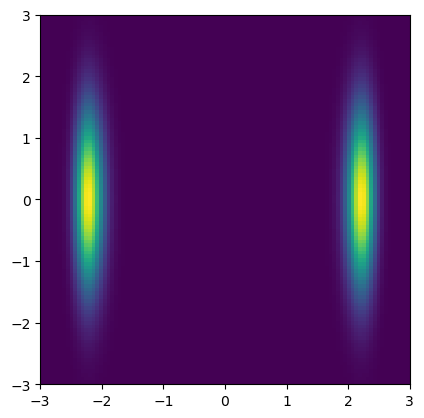

In [3]:
# define system: double well potential
from bgflow import DoubleWellEnergy
dim = 2
target = DoubleWellEnergy(dim, b=-10,c=1)
plot_energy(target, dim=dim)

In [4]:
# set up a prior
from bgflow import NormalDistribution
cov = torch.zeros((2,2), dtype=torch.float)
cov[0,0]=0.01
cov[1,1]=0.01
prior = NormalDistribution(2, cov=cov)

In [5]:
# define a flow with RNVP coupling layers (from example)
from bgflow.nn import (
    DenseNet,
    SequentialFlow, 
    CouplingFlow, 
    AffineFlow, 
    SplitFlow, 
    InverseFlow, 
    SwapFlow,
    AffineTransformer
)
# here we aggregate all layers of the flow
layers = []

# start with a splitting layer which splits the input tensor into two 
# flow channels with tensors of half dimensionality
layers.append(SplitFlow(dim // 2))

# now add coupling layers
n_coupling_layers = 4
for _ in range(n_coupling_layers):
    # we need to swap dimensions for the mixing
    layers.append(SwapFlow())
    
    # now set up a coupling block
    layers.append(CouplingFlow(
        # we use a affine transformation to transform the RHS conditioned on the LHS
        AffineTransformer(
            # use simple dense nets for the affine shift/scale
            shift_transformation=DenseNet([dim // 2, 64, 64, dim // 2], activation=torch.nn.ReLU()), 
            scale_transformation=DenseNet([dim // 2, 64, 64, dim // 2], activation=torch.nn.ReLU())
        )
    ))
    
# finally, we have to merge the two channels again into one tensor
layers.append(InverseFlow(SplitFlow(dim // 2)))

# now define the flow as a sequence of all operations stored in layers
flow = SequentialFlow(layers)

In [6]:
# define a Boltzmann Generator (target is the Energy to be sampled from)
from bgflow import BoltzmannGenerator
bg = BoltzmannGenerator(prior, flow, target)

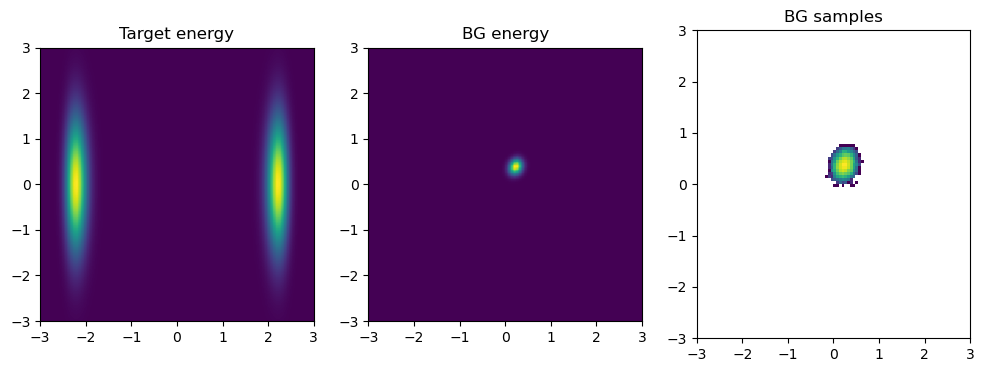

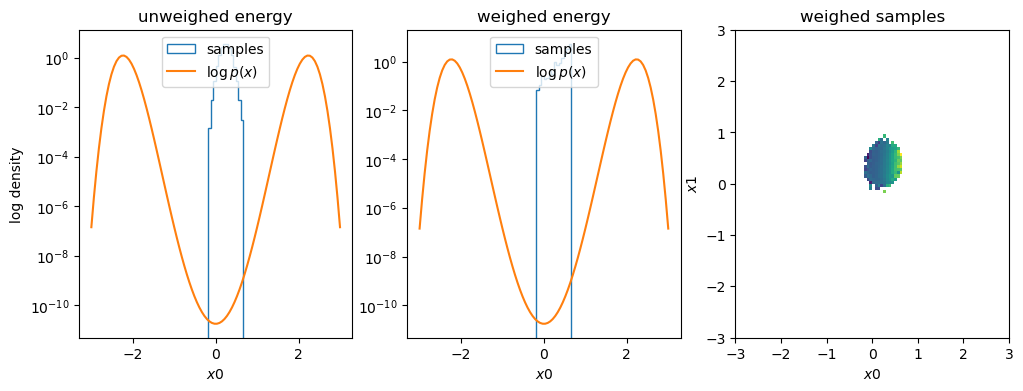

In [7]:
# initial bg should not be useful
plot_bg(bg, target, dim=dim)

plot_weighted_energy_estimate(bg, target)

In [8]:
# define loss (where do we set the temperature?)
from bgflow.utils.types import is_list_or_tuple

class LossReporter:
    """
        Simple reporter use for reporting losses and plotting them.
    """
    def __init__(self, *labels):
        self._labels = labels
        self._n_reported = len(labels)
        self._raw = [[] for _ in range(self._n_reported)]
    
    def report(self, *losses):
        assert len(losses) == self._n_reported
        for i in range(self._n_reported):
            self._raw[i].append(assert_numpy(losses[i]))
    
    def plot(self, n_smooth=10):
        fig, axes = plt.subplots(self._n_reported, sharex=True)
        if not isinstance(axes, np.ndarray):
            axes = [axes]
        fig.set_size_inches((8, 4 * self._n_reported), forward=True)
        for i, (label, raw, axis) in enumerate(zip(self._labels, self._raw, axes)):
            raw = assert_numpy(raw).reshape(-1)
            kernel = np.ones(shape=(n_smooth,)) / n_smooth
            smoothed = np.convolve(raw, kernel, mode="valid")
            axis.plot(smoothed)
            axis.set_ylabel(label)
            if i == self._n_reported - 1:
                axis.set_xlabel("Iteration")
                
    def recent(self, n_recent=1):
        return np.array([raw[-n_recent:] for raw in self._raw])

In [9]:
# training without sampling (different from example but similar to 2019 paper)
size_batch = 100
optim = torch.optim.Adam(bg.parameters(), lr=5e-3)
n_epochs = 5
n_report_steps = 50
n_samples = 1000

n_batches = 100

T = 1

reporter = LossReporter("NLL")
for epoch in range(n_epochs):
    for it in range(n_batches):
        optim.zero_grad()

        # kl divergence to the target
        kll = bg.kldiv(n_samples).mean()

        # aggregate weighted gradient
        kll.backward()
        
        reporter.report(kll)
        
        optim.step()
        
        if it % n_report_steps == 0:
            print("\repoch: {0}, iter: {1}/{2}, KL: {3:.4}".format(
                    epoch,
                    it,
                    n_batches,
                    *reporter.recent(1).ravel()
                ), end="")
        


epoch: 4, iter: 50/100, KL: -26.79

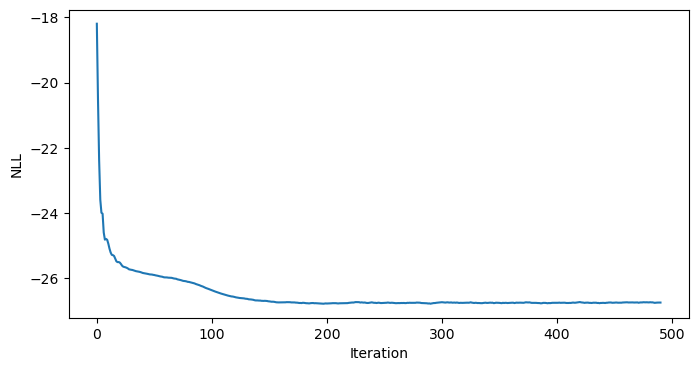

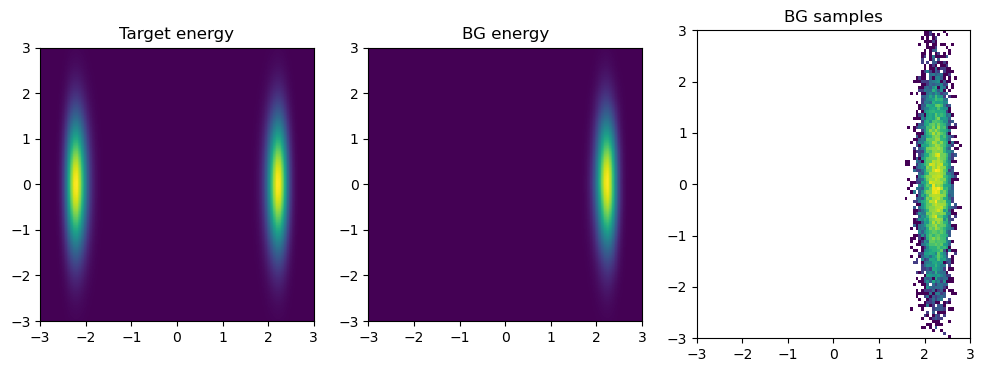

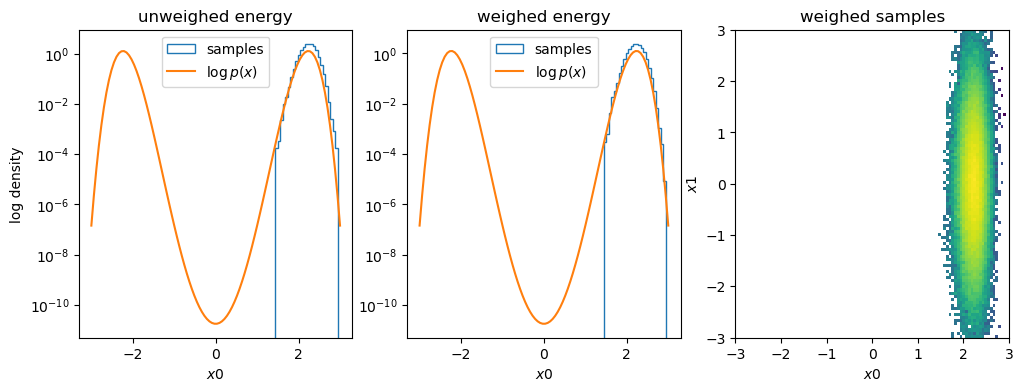

In [10]:
reporter.plot()

plot_bg(bg, target, dim=dim)

plot_weighted_energy_estimate(bg, target, dim=dim)